In [1]:
from sklearn import datasets
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.layers import Layer, InputSpec, ReLU
from tensorflow.keras.initializers import Ones
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class MAct(Layer):

    def __init__(self, **kwargs):
        super(MAct, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        self.c = self.add_weight(name="c",
                                shape=(input_shape[1],),
                                initializer='ones',
                                trainable=True) # Initialiseerida c ühtedeks / nullideks
        self.b = self.add_weight(name="b",
                                shape=(input_shape[1],),
                                initializer='ones',
                                trainable=True) # Initialiseerida b nullideks
        super(MAct, self).build(input_shape)
        

    def call(self, inputs):
        first_exp = tf.exp(self.c - tf.square(inputs))

        p = (first_exp + tf.exp(self.b)) / tf.reduce_sum(first_exp + tf.exp(self.b), axis=1, keepdims=True)
        
        #p = tf.exp(inputs) / tf.reduce_sum(tf.exp(inputs), axis=0, keepdims=True)
        return p

    def compute_output_shape(self, input_shape):
        return input_shape

In [3]:
def cross_ent(probs, y):
    #losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y) # Tavaline CE
    cce = CategoricalCrossentropy()
    losses = cce(probs, y)
    return tf.reduce_mean(losses)


def max_conf(probs, dim):
    y = tf.argmax(probs, 1)
    y = tf.one_hot(y, dim)
    #losses = -tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y) # Tavaline CE
    cce = CategoricalCrossentropy()
    losses = -cce(probs, y)
    return tf.reduce_mean(losses)

In [4]:
def gen_adv(x, dim):
    eps = 0.025
    n_iters = 4
    step_size = 0.02

    unif = tf.random.uniform(minval=-eps, maxval=eps, shape=tf.shape(x))
    x_adv = tf.clip_by_value(x + unif, 0., 1.)
    
    for i in range(n_iters):
        x_adv = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            loss = max_conf(model(x_adv), dim)
            grad = tape.gradient(loss, x_adv)
            g = tf.sign(grad)

        x_adv_start = x_adv + step_size*g
        x_adv = tf.clip_by_value(x_adv, 0., 1.)
        delta = x_adv - x_adv_start
        delta = tf.clip_by_value(delta, -eps, eps)
        x_adv = x_adv_start + delta

    return x_adv

In [5]:
def plot(model, plot_min, plot_max, max_prob, layers, X, y):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    probs = model(points).numpy()
    #probs = tf.nn.softmax(logits).numpy()
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y)
    X0 = X[y_np.argmax(1)==0]
    X1 = X[y_np.argmax(1)==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('one_train_one_train/{}_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
        layers, plot_min, plot_max, max_prob), transparent=True)
    plt.clf()
    #plt.show()

In [6]:
def model_experiment(model, layers, optimizer, acet):
    for n_iter in [200, 400, 600, 800, 1000]:
        dim = 2
        # More noise in the moons makes the task harder
        X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.02)
        # Rescale and shift the dataset to better fit into zero-one box
        X = (X + 1.6) / 4
        X[:, 0] = X[:, 0] - 0.035
        X[:, 1] = (X[:, 1] - 0.17) * 1.75
        y = tf.one_hot(y, dim)

        X_test, y_test = datasets.make_moons(n_samples=400, shuffle=True, noise=.02)
        X_test = (X_test + 1.6) / 4
        X_test[:, 0] = X_test[:, 0] - 0.035
        X_test[:, 1] = (X_test[:, 1] - 0.17) * 1.75

        info_list = []

        # Custom training cycle going through the entire dataset
        for epoch in range(1, n_iter+1):
            X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]])
            # If we use the ACET method, then adversarial noise will be generated
            if acet:
                X_noise = gen_adv(X_noise, dim)
            # Context used to calculate the gradients of the model
            with tf.GradientTape() as tape:
                logits = model(X)
                logits_noise = model(X_noise)
                loss_main = cross_ent(logits, y)
                loss_acet = acet * max_conf(logits_noise, dim)
                loss = loss_main + loss_acet
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            if epoch % 100  == 0:
                train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
                #print("Iter {:03d}: loss_main={:.10f} loss_acet={:.3f} err={:.2%}"
                #      .format(epoch, loss_main, loss_acet, train_err))

                weights = model.layers[-1].get_weights()
                info_list.append("Iter {:03d}: loss_main={:.10f} loss_acet={:.6f} err={:.2%} c: {}, b: {}"
                                 .format(epoch, loss_main, loss_acet, train_err, weights[0], weights[1]))
            
        #logits = model(X_test)
        #loss_test = cross_ent(logits, y_test)
        #info_list.append("Test: loss_test={:.10f}".format(loss_test))

        file_name = "one_train_one_train/{}_iters={}.csv".format(layers, n_iter)
        with open(file_name, 'w', newline='') as myfile:
            wr = csv.writer(myfile, delimiter="\n")
            wr.writerow(info_list)

        plot(model, 0.0, 1.0, True, layers + "_iters={}".format(n_iter), X, y)
        #plot(model, 0.3, 0.5, max_prob=True, layers)
        plot(model, -2.0, 3.0, True, layers + "_iters={}".format(n_iter), X, y)
        plot(model, -5.0, 6.0, True, layers + "_iters={}".format(n_iter), X, y)
        plot(model, -10.0, 10.0, True, layers + "_iters={}".format(n_iter), X, y)

In [ ]:
# How many layers
for number_layers in range(2,3):
    # How many nodes in first dense
    for dense_1 in range(20, 110, 20):
        # What is the first activation layer
        for activation_1 in ['selu', 'sigmoid', 'relu', 'tanh']:
            # If the number of hidden layers is 1
            if number_layers == 1:
                for l_rate in [0.001, 0.01, 0.1]:
                    for acet in [True, False]:
                        model = Sequential([
                            Dense(dense_1, input_shape=(2,)),
                            Activation(activation_1),
                            Dense(2),
                            MAct()
                        ])
                        optim = Adam(learning_rate=l_rate)
                        lay = "d={}_act={}_l_rate={}_acet={}".format(dense_1, activation_1, l_rate, acet)
                        model_experiment(model, lay, optim, acet)
            # If the number of hidden layers is 2
            else:
                for dense_2 in range(100, 110, 20):
                    for activation_2 in ['selu', 'sigmoid', 'relu', 'tanh']:
                        for l_rate in [0.001, 0.01, 0.1]:
                            for acet in [True, False]:
                                model = Sequential([
                                    Dense(dense_1, input_shape=(2,)),
                                    Activation(activation_1),
                                    Dense(dense_2),
                                    Activation(activation_2),
                                    Dense(2),
                                    MAct()
                                ])
                                optim = Adam(learning_rate=l_rate)
                                lay = "d={}_act={}_d={}_act={}_l_rate={}_acet={}".format(dense_1, activation_1, 
                                                                                         dense_2, activation_2, l_rate, acet)
                                model_experiment(model, lay, optim, acet)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [3]:
model = Sequential([
    Dense(100,input_shape=(2,)),
    Activation('selu'),
    Dense(100),
    Activation('selu'),
    Dense(2),
    MAct(),
    #Activation('softmax')
])

optimizer = Adam(learning_rate=0.01)

In [4]:
dim = 2
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.02)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

In [5]:
X_test, y_test = datasets.make_moons(n_samples=400, shuffle=True, noise=.02)
X_test = (X_test + 1.6) / 4
X_test[:, 0] = X_test[:, 0] - 0.035
X_test[:, 1] = (X_test[:, 1] - 0.17) * 1.75

In [6]:
y = tf.one_hot(y, dim)

In [9]:
acet = False

In [10]:
if acet:
    n_iter = 900
else:
    n_iter = 900

In [11]:
weights_list = []

# Custom training cycle going through the entire dataset
for epoch in range(1, n_iter+1):
    X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]])
    # If we use the ACET method, then adversarial noise will be generated
    if acet:
        X_noise = gen_adv(X_noise)
    # Context used to calculate the gradients of the model
    with tf.GradientTape() as tape:
        logits = model(X)
        logits_noise = model(X_noise)
        loss_main = cross_ent(logits, y)
        loss_acet = acet * max_conf(logits_noise)
        loss = loss_main + loss_acet
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100  == 0:
        train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
        print("Iter {:03d}: loss_main={:.10f} loss_acet={:.3f} err={:.2%}"
              .format(epoch, loss_main, loss_acet, train_err))
        
        weights = model.layers[-1].get_weights()
        weights_list.append("c: {}, b: {}".format(weights[0], weights[1]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iter 100: loss_main=4.3747119904 loss_acet=-0.000 err=9.65%
Iter 200: loss_main=1.7157150507 loss_acet=-0.000 err=0.00%
Iter 300: loss_main=0.8929836154 loss_acet=-0.000 err=0.00%
Iter 400: loss_main=0.5422356129 loss_acet=-0.000 err=0.00%
Iter 500: loss_main=0.3714447320 loss_acet=-0.000 err=0.00%
Iter 600: loss_main=0.2731063366 loss_acet=-0.000 err=0.00%
Iter 700: loss_main=0.2105830163 loss_acet=-0.000 err=0.00%
Iter 800: loss_main=0.1680104285 loss_acet=-0.000 err=0.00%
Iter 900: loss_main=0.137523

In [12]:
test_accuracy = tf.keras.metrics.Accuracy()


for idx in range(len(X_test)):
    sample_test = X_test[idx]
    target_test = y_test[idx]

    # Adding batch dim since batch=1
    sample_test = np.expand_dims(sample_test, axis=0)
    target_test = np.expand_dims(target_test, axis=0)

    # To tensors
    sample_test = K.constant(sample_test)
    target_test = K.constant(target_test)
        
    logits = model(sample_test)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    #print(prediction.shape)
    #print(target_test.shape)
    test_accuracy(prediction, target_test)
    

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 100.000%


In [13]:
print(weights_list)

['c: [2.0707293 2.048267 ], b: [1. 1.]', 'c: [3.1125352 3.0621438], b: [1. 1.]', 'c: [3.871858  3.8434265], b: [1. 1.]', 'c: [4.376797 4.361787], b: [1. 1.]', 'c: [4.7614646 4.753905 ], b: [1. 1.]', 'c: [5.0730534 5.0698113], b: [1. 1.]', 'c: [5.3357415 5.3352914], b: [1. 1.]', 'c: [5.5635543 5.565012 ], b: [1. 1.]', 'c: [5.765257 5.768091], b: [1. 1.]']


In [241]:
with open('mact_dense100_selu_dense100_selu_dense2_mact_no_acet_0.001_b_frozen_ones_z_abs900.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, delimiter="\n")
    wr.writerow(weights_list)

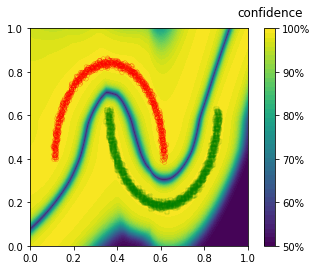

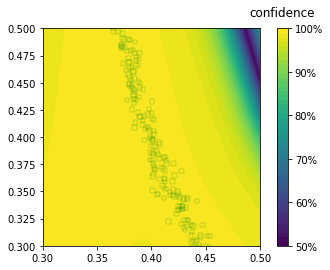

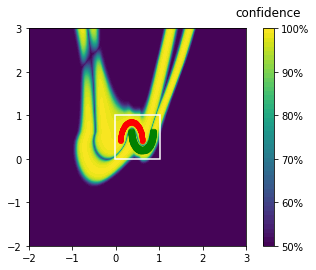

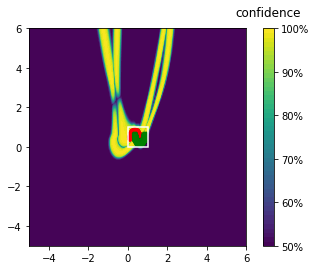

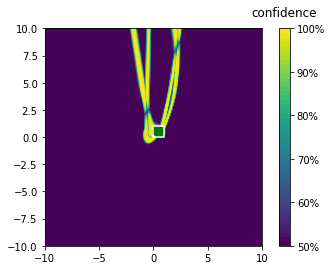

In [15]:
plot(model, 0.0, 1.0, max_prob=True)
#plot(model, 0.3, 0.5, max_prob=True)
plot(model, -2.0, 3.0, max_prob=True)
plot(model, -5.0, 6.0, max_prob=True)
plot(model, -10.0, 10.0, max_prob=True)

In [134]:
weights = model.layers[-1].get_weights()
print('c:', weights[0])
print('b:', weights[1])

c: [0.9785716 0.9210024]
b: [-0.9543602 -0.9543602]


In [268]:
for layer in model.layers:
    print(layer.get_weights())

[array([[-0.5428169 ,  0.23567562, -0.07776379,  0.04618938,  0.09044392,
        -0.14229243, -0.20757382,  0.07028708, -0.15074916, -0.20390311,
        -0.3845685 ,  0.39416412, -0.12063653,  0.05148071, -0.04625471,
        -0.24921475, -0.1948112 , -0.19097015,  0.2794209 ,  0.01780919,
         0.20495333,  0.0095434 , -0.12963448,  0.30371854,  0.10006017,
        -0.27776176, -0.10968605, -0.17811263, -0.1433618 , -0.12162988,
        -0.04110182,  0.07706167,  0.05049568, -0.17875701, -0.3860328 ,
         0.00505842, -0.07291196, -0.40722618, -0.2156284 ,  0.59235203,
        -0.10897525, -0.18519719,  0.28934336,  0.19387358, -0.47636503,
         0.00747395,  0.30338395, -0.09336103, -0.04342851,  0.47588977,
        -0.30900022,  0.36815625,  0.2563057 ,  0.06379744, -0.4346934 ,
         0.12503102, -0.17250131,  0.03874268, -0.21635582,  0.08271933,
        -0.17173694, -0.25641367,  0.19416445,  0.20860513,  0.03182077,
         0.35642928, -0.28067616,  0.23416221,  0.

In [361]:
print(model.predict(X_test))

[[0.9917779  0.0082221 ]
 [0.99181396 0.00818609]
 [0.99178785 0.00821214]
 [0.99180764 0.00819241]
 [0.9918681  0.00813194]
 [0.99180657 0.00819343]
 [0.991868   0.00813194]
 [0.00825241 0.9917476 ]
 [0.00845164 0.99154836]
 [0.00826538 0.9917346 ]
 [0.00825361 0.99174637]
 [0.9918793  0.00812077]
 [0.00833446 0.99166554]
 [0.00977368 0.99022627]
 [0.99181867 0.00818132]
 [0.00842402 0.991576  ]
 [0.0084581  0.99154186]
 [0.00825902 0.99174094]
 [0.9918433  0.00815674]
 [0.0083949  0.9916051 ]
 [0.9918433  0.00815668]
 [0.00834846 0.99165154]
 [0.00831379 0.9916862 ]
 [0.00826853 0.9917314 ]
 [0.00838075 0.9916192 ]
 [0.9918592  0.0081408 ]
 [0.991834   0.00816604]
 [0.99175256 0.00824744]
 [0.991868   0.00813203]
 [0.0082559  0.9917441 ]
 [0.9918566  0.00814345]
 [0.99176836 0.00823161]
 [0.9918361  0.00816392]
 [0.00826483 0.9917351 ]
 [0.00826734 0.9917327 ]
 [0.00826691 0.9917331 ]
 [0.9918693  0.0081307 ]
 [0.00827216 0.9917278 ]
 [0.99171704 0.00828297]
 [0.9916154  0.00838456]
